In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
import xgboost as xgb
import matplotlib.pyplot as plt

不同的带电粒子在磁场中运动的轨迹参数和在探测器中留下的信息是不一样的。
本项目是利用利用粒子在探测器中的飞行信息和击中信息，对粒子种类进行鉴别。待鉴别粒子种类为电子(Electron)和$\pi$介子(pion)

In [4]:
data_e = pd.read_table('e_info.dat',header=None,sep=' ')
data_pi = pd.read_table('pi_info.dat',header=None,sep=' ')

data_e.columns=['P','CosTheta','CosPhi','PH','GoodHit','Tof','E','Eseed','E3x3','E5x5','secp','IsE','IsPi']
data_pi.columns=['P','CosTheta','CosPhi','PH','GoodHit','Tof','E','Eseed','E3x3','E5x5','secp','IsE','IsPi']
data_tot=data_e.append(data_pi,ignore_index=True)

## 1.数据处理
通过蒙特卡洛法产生两种粒子约14万个事例，共记录每个事例的11个参数，参数从左到右分别为
动量（P），极角（CosTheta），方位角（CosPhi），脉冲信号（PH），信号击中数（GoodHit），飞行时间（Tof），能量（E），种子能量（Eseed），3x3晶格能量（E3x3），5x5晶格能量（E5x5），能量分布二阶矩（secp）

#### 关于能量
粒子能量是通过一个平面网格化的量能器来获取的，粒子击中一个晶格种子后，沉积下一部分能量，并且此能量会在周围的晶格扩散，因此会有种子能量、3x3晶格、5x5晶格的能量，能量二阶矩用于衡量扩散的范围。

### 数据清洗
首先观察一下各列数据的分布

In [5]:
data_tot.describe()

,P,CosTheta,CosPhi,PH,GoodHit,Tof,E,Eseed,E3x3,E5x5,secp,IsE,IsPi
count,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000,284890.000000
mean,0.842383,-0.000515,0.006700,494.864633,25.060023,473.147886,0.578064,0.341771,0.502831,0.527987,17.701721,0.572839,0.427161
std,0.392847,0.527450,0.706336,71.553568,3.627153,2115.319572,0.403460,0.283452,0.374599,0.382936,12.623808,0.494667,0.494667
min,0.114329,-0.950036,-0.999999,234.167000,2.000000,-44.559600,0.008165,0.005986,0.006582,0.007589,0.022062,0.000000,0.000000
25%,0.517763,-0.452995,-0.698055,429.143000,24.000000,2.876220,0.219889,0.117195,0.177883,0.188207,10.681625,0.000000,0.000000
50%,0.839065,-0.001284,0.014237,513.179000,25.000000,3.183420,0.453462,0.226160,0.376881,0.410136,14.719250,1.000000,0.000000
75%,1.166527,0.451876,0.711994,550.655000,27.000000,3.917017,0.885410,0.523328,0.790571,0.820902,21.190200,1.000000,1.000000
max,56.114500,0.941366,1.000000,6300.640000,38.000000,9999.000000,1.548800,1.266100,1.434180,1.454730,703.090000,1.000000,1.000000


利用蒙卡事例产生粒子动量为0-1.5(GeV)的均匀分布。但是可以看到得到的最低动量为0.11GeV，最高动量为56GeV。
由于动量越低，在探测器中飞行的径迹越短，因此动量太低的粒子有可能重建失败，信息丢失。
探测器记录飞行信息时有可能产生错误，用此错误信息计算出的动量有可能会出错，因此动量大于1.5GeV的事例我们决定抛弃，避免这些事例对之后建立模型产生影响。

In [6]:
print("Number of event with abnormal hith momentum: "+str(data_tot[data_tot['P']>1.5].count()[0])) #打印动量异常过高的事例数
data_tot=data_tot[data_tot['P']<=1.5] #删除动量异常过高事例
data_tot.describe()

Number of event with abnormal hith momentum: 1547


,P,CosTheta,CosPhi,PH,GoodHit,Tof,E,Eseed,E3x3,E5x5,secp,IsE,IsPi
count,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000,283343.000000
mean,0.838146,-0.000716,0.004917,494.928634,25.074920,473.489555,0.576584,0.340789,0.501494,0.526585,17.708073,0.573499,0.426501
std,0.374552,0.527164,0.706222,71.587703,3.609151,2116.051972,0.401991,0.282425,0.373242,0.381548,12.622585,0.494569,0.494569
min,0.114329,-0.950036,-0.999999,234.167000,2.000000,-44.559600,0.008165,0.005986,0.006582,0.007589,0.022062,0.000000,0.000000
25%,0.516063,-0.453009,-0.699669,429.145500,24.000000,2.876405,0.219805,0.116997,0.177787,0.188126,10.690150,0.000000,0.000000
50%,0.835546,-0.001603,0.010508,513.300000,25.000000,3.183390,0.452523,0.225697,0.376043,0.409078,14.724000,1.000000,0.000000
75%,1.160960,0.451585,0.710126,550.692000,27.000000,3.915530,0.882969,0.521543,0.788498,0.818615,21.193350,1.000000,1.000000
max,1.500000,0.941366,1.000000,6300.640000,38.000000,9999.000000,1.548800,1.266100,1.419480,1.451080,703.090000,1.000000,1.000000


下边画一下各个变量的分布情况

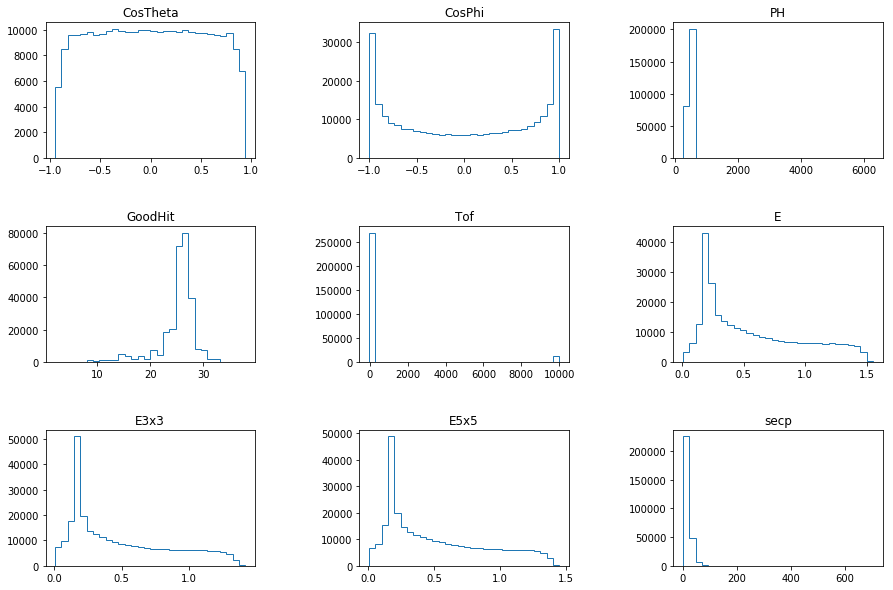

In [7]:

plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(331)
plt.hist(data_tot['CosTheta'],30,histtype='step')

plt.title(u"CosTheta")

plt.subplot(332)
plt.hist(data_tot['CosPhi'],30,histtype='step')
plt.title(u"CosPhi")


plt.subplot(333)
plt.hist(data_tot['PH'],30,histtype='step')
plt.title(u"PH")

plt.subplot(334)
plt.hist(data_tot['GoodHit'],30,histtype='step')
plt.title(u"GoodHit")

plt.subplot(335)
plt.hist(data_tot['Tof'],30,histtype='step')
plt.title(u"Tof")

plt.subplot(336)
plt.hist(data_tot['E'],30,histtype='step')
plt.title(u"E")

plt.subplot(337)
plt.hist(data_tot['E3x3'],30,histtype='step')
plt.title(u"E3x3")

plt.subplot(338)
plt.hist(data_tot['E5x5'],30,histtype='step')
plt.title(u"E5x5")

plt.subplot(339)
plt.hist(data_tot['secp'],30,histtype='step')
plt.title(u"secp")



plt.show()


### 异常值处理

由以上几张图可以看到，PH、Tof、secp这三个分布是有异常数据的，有些异常数据过大导致看不出来整体分布。

对于PH和secp，可以看到数值较高的事例比较少，简便起见，我们将这两个数值偏离均值超过5个标准差的数据删除。

In [8]:
PH_std=data_tot['PH'].std()
PH_mean=data_tot['PH'].mean()
secp_std=data_tot['secp'].std()
secp_mean=data_tot['secp'].mean()
data_tot=data_tot[data_tot['PH']<=PH_mean+5*PH_std] #删除PH异常过高事例
data_tot=data_tot[data_tot['secp']<=secp_mean+5*secp_std] #删除secp异常过高事例




对于飞行时间Tof，异常情况比较复杂。
从Tof的大致分布可以看到，飞行时间基本上处于(2-10)区间，而根据上图又有很多事例其飞行时间固定在9999。因此需要分别对这几种情况进行处理。

首先对于值小于0时，可以认为是探测器计算此值时出现异常，因为飞行时间一定是大于0的，在20万的事例中有12个事例出现这种情况，简便起见可以将这些事例删除

飞行时间大于10的事例也可以认为是异常事例，20万事例中有70个出现这种情况，同样我们会将其删除。

最后是飞行时间为9999的，这种事例占比超过5%，因此不能简单将其删除。查看原始数据发现，这些事例是由于粒子没有击中飞行时间探测器造成的(因为探测器是有缝隙，粒子可能从缝隙中飞出)。对于这种存在大量异常值的数据，可以有以下几种处理方法：
>* 1.不处理，这种方法可以避免引入噪声。有些模型能够自动对这些异常值处理得好，有些对距离敏感的分类器则会导致性能下降(如KNN)
>* 2.直接填充均值，这种方法十分简单，但是可能会引入噪声，改变填充后的数据分布
>* 3.热卡填补，此法是在完整数据中找一个与其最相似的对象，并用其值来填充。此法主观性较强，因此需要自行挑选用哪些特征来进行匹配，但是如果对数据的类型比较熟悉的话，此法会比较有效，因此下边将会用此法进行异常值校正。
>* 4.拟合，利用其他变量对异常值进行预测，此法与正常建模方法一样，只是目标变量变为预测值。但是这种方法得出的值可能会对最后的建模起不到太大作用，因为此预测值必然与其他特征相关性较高。


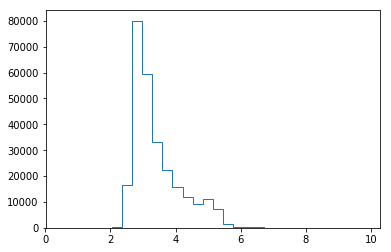

Number of events with Tof<0: 12
Number of events with 10<Tof<9999: 70
Number of events with Tof==9999: 13005


In [9]:
plt.hist(data_tot.loc[((data_tot['Tof']<10)&(data_tot['Tof']>0)),'Tof'],30,histtype='step')
plt.show()
print("Number of events with Tof<0: "+ str(data_tot[data_tot['Tof']<=0].count()[0]))
print("Number of events with 10<Tof<9999: "+ str(data_tot.loc[(data_tot['Tof']>10)&(data_tot['Tof']<9999)].count()[0]))
print("Number of events with Tof==9999: "+ str(data_tot[data_tot['Tof']==9999].count()[0]))

在此处我决定用动量P和极角CosTheta来匹配对应的飞行时间，因为飞行时间必然与粒子的速度(动量)和飞行距离相关，而由于探测器是圆柱体结构，所以粒子出射角度(CosTheta)与飞行距离相关。
匹配方法为：将动量P和极角CosTheta各分成5个区间，总共有25个子区间。求出每个区间粒子的Tof中位数。将Tof异常值的事例根据其动量和极角匹配到区间中的Tof值

In [10]:
guess_TOF=np.zeros((5,5))
step_P=(data_tot['P'].max()-data_tot['P'].min())/5
step_Cos=(data_tot['CosTheta'].max()-data_tot['CosTheta'].min())/5

MinP=data_tot['P'].min()
MinC=data_tot['CosTheta'].min()

data_tot=data_tot[(data_tot['Tof']<10)&(data_tot['Tof']>0)]

#填充25个小区间里Tof的中位数
for i in range(0,5):
    for j in range(0,5):
        guess_data=data_tot[(data_tot['P']>MinP+(i*step_P))&(data_tot['P']<MinP+(i+1)*step_P)
                           &(data_tot['CosTheta']>MinC+j*step_Cos)&(data_tot['CosTheta']<MinC+(j+1)*step_Cos)
                           &(data_tot['Tof']!=9999)]['Tof'].median()
        
        guess_TOF[i,j]=guess_data

#替换Tof值为9999的事例
for i in range(0,5):
    for j in range(0,5):
        data_tot.loc[(data_tot['P']>=MinP+(i*step_P))&(data_tot['P']<MinP+(i+1)*step_P)
        &(data_tot['CosTheta']>=MinC+j*step_Cos)&(data_tot['CosTheta']<MinC+(j+1)*step_Cos)
        &(data_tot['Tof']==9999),'Tof']=guess_TOF[i,j]
      


观察一下各个特征对两个标签的相关性

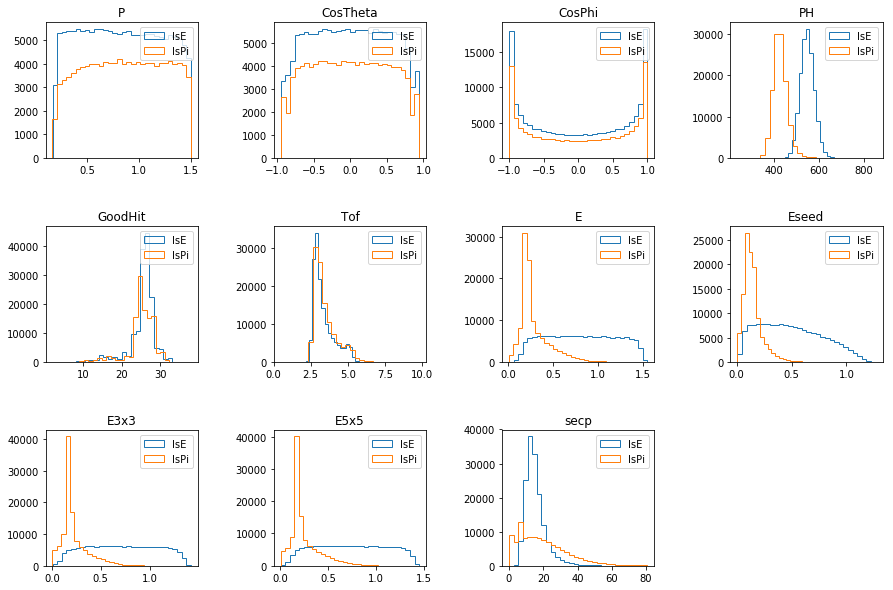

In [11]:

plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距

plt.subplot(341)
plt.hist(data_tot.loc[data_tot['IsE']==1,'P'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'P'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"P")

plt.subplot(342)
plt.hist(data_tot.loc[data_tot['IsE']==1,'CosTheta'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'CosTheta'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"CosTheta")

plt.subplot(343)
plt.hist(data_tot.loc[data_tot['IsE']==1,'CosPhi'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'CosPhi'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"CosPhi")


plt.subplot(344)
plt.hist(data_tot.loc[data_tot['IsE']==1,'PH'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'PH'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"PH")



plt.subplot(345)
plt.hist(data_tot.loc[data_tot['IsE']==1,'GoodHit'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'GoodHit'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"GoodHit")

plt.subplot(346)
plt.hist(data_tot.loc[data_tot['IsE']==1,'Tof'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'Tof'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"Tof")

plt.subplot(347)
plt.hist(data_tot.loc[data_tot['IsE']==1,'E'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'E'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"E")

plt.subplot(348)
plt.hist(data_tot.loc[data_tot['IsE']==1,'Eseed'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'Eseed'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"Eseed")

plt.subplot(349)
plt.hist(data_tot.loc[data_tot['IsE']==1,'E3x3'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'E3x3'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"E3x3")

plt.subplot(3,4,10)
plt.hist(data_tot.loc[data_tot['IsE']==1,'E5x5'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'E5x5'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"E5x5")


plt.subplot(3,4,11)
plt.hist(data_tot.loc[data_tot['IsE']==1,'secp'],30,histtype='step',label=u'IsE')
plt.hist(data_tot.loc[data_tot['IsE']==0,'secp'],30,histtype='step',label=u'IsPi')
plt.legend(loc='best')
plt.title(u"secp")


plt.show()


以上图是没有经过归一化的，电子和pi的样本数量并不一样，所以有些图看起来高度不一致。

但是很明显可以看出，有几个特征其与标签是有很强相关性的，分别是PH，E，Eseed，E3x3,E5x5,secp

最后在训练模型前，将数据进行归一化处理，有助于模型更快收敛

In [12]:
IsE=data_tot['IsE']
IsPi=data_tot['IsPi']
data_tot = (data_tot - data_tot.mean()) / (data_tot.std())
data_tot.drop(['IsE','IsPi'],axis=1,inplace=True)
data_tot.insert(11,'IsE',IsE)
data_tot.insert(12,'IsPi',IsPi)

data_tot.describe()

,P,CosTheta,CosPhi,PH,GoodHit,Tof,E,Eseed,E3x3,E5x5,secp,IsE,IsPi
count,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,2.692810e+05,269281.000000,269281.000000
mean,-2.338238e-14,-4.142706e-17,1.102963e-17,2.688484e-14,-2.517288e-17,-6.000370e-14,6.859688e-15,-2.313245e-14,1.163209e-14,-4.105681e-14,-8.337342e-15,0.575354,0.424646
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.494290,0.494290
min,-1.809219e+00,-1.843746e+00,-1.422451e+00,-3.850471e+00,-6.542609e+00,-3.915518e+00,-1.438493e+00,-1.201897e+00,-1.347660e+00,-1.381789e+00,-1.571980e+00,0.000000,0.000000
25%,-8.569940e-01,-8.492263e-01,-9.979038e-01,-9.697907e-01,-4.493478e-02,-7.258758e-01,-9.013300e-01,-7.995612e-01,-8.825751e-01,-8.997704e-01,-5.996422e-01,0.000000,0.000000
50%,-4.142555e-03,-1.650666e-03,7.147788e-03,2.741349e-01,2.375728e-01,-3.542427e-01,-2.992966e-01,-4.002398e-01,-3.245832e-01,-2.963731e-01,-2.388668e-01,1.000000,0.000000
75%,8.612583e-01,8.498237e-01,9.990030e-01,8.235989e-01,5.200804e-01,4.619940e-01,7.708434e-01,6.508143e-01,7.790079e-01,7.737612e-01,3.310375e-01,1.000000,1.000000
max,1.763155e+00,1.835597e+00,1.409186e+00,5.280526e+00,3.627664e+00,8.569940e+00,2.394999e+00,3.247336e+00,2.432457e+00,2.396994e+00,5.796162e+00,1.000000,1.000000


将数据随机打乱后，按照6：2：2的比例将数据分为训练集、验证集和测试集

In [13]:
data_tot=data_tot.values

permutation = np.random.permutation(data_tot.shape[0])
data_tot = data_tot[permutation]
sh = data_tot.shape

train = data_tot[:int(sh[0] * 0.6), :]
test = data_tot[int(sh[0] * 0.6):int(sh[0] * 0.8), :]
val = data_tot[int(sh[0] * 0.8):, :]

train_X = train[:, 0:11]
train_Y = train[:, 11:]

test_X = test[:, 0:11]
test_Y = test[:, 11:]

val_X = val[:, 0:11]
val_Y = val[:, 11:]

下边利用tflearn构建全连接层神经网络。输入为11维特征，中间经过4个隐藏层，最后经过softmax输出二维结果。

四个隐藏层用的激活函数都是Relu。并且采用L2正则化以及每次只训练每层80%节点来减少网络过拟合。

损失函数采用的是交叉熵损失函数，其是典型的多分类问题采用的损失函数。

因为数据并不复杂，能够较快收敛，所以训练轮数采取3轮即可，训练结束后在测试集上的预测准确率超过99%

In [14]:
input_layer = tflearn.input_data(shape=[None, 11])
dense1 = tflearn.fully_connected(input_layer, 32, activation='relu', regularizer='L2', weight_decay=0.001)
dropout1 = tflearn.dropout(dense1, 0.8)

dense2 = tflearn.fully_connected(dropout1, 64, activation='relu',regularizer='L2', weight_decay=0.001)
dropout2 = tflearn.dropout(dense2, 0.8)

dense3 = tflearn.fully_connected(dropout2, 128, activation='relu',regularizer='L2', weight_decay=0.001)
dropout3 = tflearn.dropout(dense3, 0.8)

dense4 = tflearn.fully_connected(dropout3, 256, activation='relu',regularizer='L2', weight_decay=0.001)
dropout4 = tflearn.dropout(dense4, 0.8)

softmax = tflearn.fully_connected(dropout4, 2, activation='softmax')


net = tflearn.regression(softmax, optimizer='adam',loss='categorical_crossentropy')

# Training

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(train_X, train_Y, n_epoch=3, validation_set=(val_X,val_Y), show_metric=True,run_id="dense_model")

acc_dnn = model.evaluate(test_X,test_Y)
print("val_data score:",model.evaluate(test_X,test_Y))


Training Step: 7574  | total loss: 0.07243 | time: 16.184s
| Adam | epoch: 003 | loss: 0.07243 - acc: 0.9839 -- iter: 161536/161568
Training Step: 7575  | total loss: 0.07409 | time: 18.059s
| Adam | epoch: 003 | loss: 0.07409 - acc: 0.9840 | val_loss: 0.02308 - val_acc: 0.9935 -- iter: 161568/161568
--
val_data score: [0.9941696375519905]


In [26]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

下边测试一下传统机器学习方法的分类性能，为了加快训练速度，训练时只采取1万个数据

In [21]:
train_X_1=train_X[0:10000]
train_Y_1=train_Y[0:10000]

In [22]:
logreg = LogisticRegression()
logreg.fit(train_X_1,train_Y_1[:,0:1])
Y_pred = logreg.predict(test_X)
acc_log = round(logreg.score(test_X, test_Y[:,0:1]) * 100, 2)
acc_log

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


98.91

In [23]:
svc = SVC()
svc.fit(train_X_1,train_Y_1[:,0:1])
acc_svc = round(svc.score(test_X, test_Y[:,0:1]) * 100, 2)
acc_svc

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


99.35

In [27]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_X_1,train_Y_1[:,0:1])
acc_decision_tree = round(decision_tree.score(test_X, test_Y[:,0:1]) * 100, 2)
acc_decision_tree

98.37

In [28]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_X_1,train_Y_1[:,0:1])
acc_knn = round(knn.score(test_X, test_Y[:,0:1]) * 100, 2)
acc_knn


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


98.98

In [29]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_X_1,train_Y_1[:,0:1])
acc_random_forest = round(random_forest.score(test_X, test_Y[:,0:1]) * 100, 2)
acc_random_forest


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


99.1

最后测试xgboost的训练结果，对测试集的正确率有99.7%

In [33]:
import xgboost as xgb
xg_train = xgb.DMatrix(train_X, label=train_Y[:,0])
xg_test = xgb.DMatrix(test_X, label=test_Y[:,0])
xg_val = xgb.DMatrix(val_X, label=val_Y[:,0])
param = {}

# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 2

watchlist = [(xg_train, 'train'), (xg_test, 'test')]

num_round = 200

param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist)

pred_prob = bst.predict(xg_test).reshape(test_Y[:,0].shape[0], 2)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y[:,0]) / test_Y[:,0].shape[0]
print('Test error using softprob = {}'.format(error_rate))

[0]	train-merror:0.011927	test-merror:0.01309
[1]	train-merror:0.011265	test-merror:0.012273
[2]	train-merror:0.010838	test-merror:0.011884
[3]	train-merror:0.010305	test-merror:0.011345
[4]	train-merror:0.009903	test-merror:0.010862
[5]	train-merror:0.009544	test-merror:0.01051
[6]	train-merror:0.009643	test-merror:0.010472
[7]	train-merror:0.009197	test-merror:0.010194
[8]	train-merror:0.008888	test-merror:0.010045
[9]	train-merror:0.008374	test-merror:0.009525
[10]	train-merror:0.007947	test-merror:0.009265
[11]	train-merror:0.007811	test-merror:0.009284
[12]	train-merror:0.00773	test-merror:0.009024
[13]	train-merror:0.007576	test-merror:0.00895
[14]	train-merror:0.007378	test-merror:0.008838
[15]	train-merror:0.007266	test-merror:0.008616
[16]	train-merror:0.007118	test-merror:0.008467
[17]	train-merror:0.006969	test-merror:0.008244
[18]	train-merror:0.00687	test-merror:0.008207
[19]	train-merror:0.006666	test-merror:0.008096
[20]	train-merror:0.006505	test-merror:0.007984
[21]	tr

[170]	train-merror:0.000427	test-merror:0.003324
[171]	train-merror:0.000427	test-merror:0.003342
[172]	train-merror:0.000421	test-merror:0.003305
[173]	train-merror:0.000427	test-merror:0.003305
[174]	train-merror:0.000427	test-merror:0.003305
[175]	train-merror:0.000415	test-merror:0.003324
[176]	train-merror:0.000384	test-merror:0.003305
[177]	train-merror:0.000378	test-merror:0.003324
[178]	train-merror:0.000384	test-merror:0.003287
[179]	train-merror:0.000365	test-merror:0.003342
[180]	train-merror:0.000353	test-merror:0.003342
[181]	train-merror:0.000353	test-merror:0.003324
[182]	train-merror:0.00034	test-merror:0.003287
[183]	train-merror:0.000334	test-merror:0.003342
[184]	train-merror:0.000328	test-merror:0.003342
[185]	train-merror:0.000328	test-merror:0.003305
[186]	train-merror:0.000334	test-merror:0.003287
[187]	train-merror:0.000334	test-merror:0.003287
[188]	train-merror:0.000334	test-merror:0.003268
[189]	train-merror:0.00034	test-merror:0.003268
[190]	train-merror:0.0

XGBoost能够计算输入特征与输出值相关性的指标，下边比较一下

In [34]:
importance=bst.get_fscore()
importance['P']=importance.pop('f0')
importance['CosTheta']=importance.pop('f1')
importance['CosPhi']=importance.pop('f2')
importance['PH']=importance.pop('f3')
importance['GoodHit']=importance.pop('f4')
importance['Tof']=importance.pop('f5')
importance['E']=importance.pop('f6')
importance['Eseed']=importance.pop('f7')
importance['E3x3']=importance.pop('f8')
importance['E5x5']=importance.pop('f9')
importance['secp']=importance.pop('f10')



In [35]:
temp1 = []
temp2 = []
for k in importance:
    temp1.append(k)
    temp2.append(importance[k])
print(pd.DataFrame({
        'column': temp1,
        'importance': temp2,
    }).sort_values(by='importance',ascending=False))

      column  importance
0          P        2856
5        Tof        2490
3         PH        2240
1   CosTheta        1874
10      secp        1468
6          E        1436
4    GoodHit        1172
8       E3x3        1088
7      Eseed        1020
9       E5x5         766
2     CosPhi         716


从以上可以看到，动量(P),脉冲高度(PH)，飞行时间(TOF)与输出值的相关性较高

下边画一下几种分类器的ROC曲线

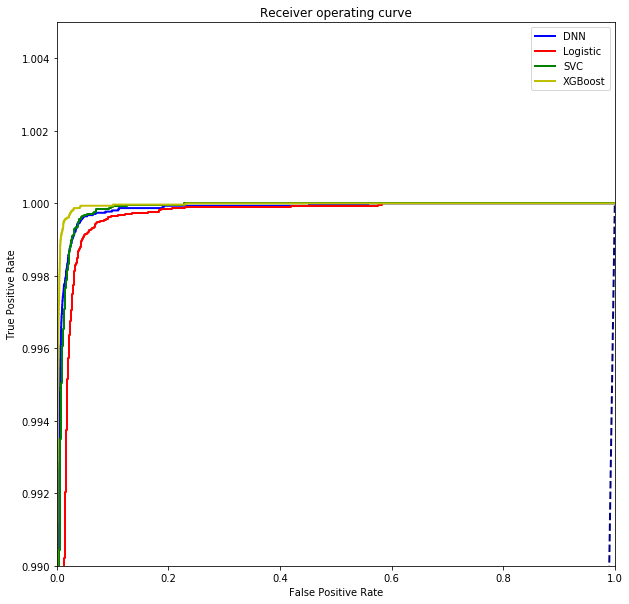

In [36]:
from sklearn.metrics import roc_curve, auc,accuracy_score
score_Y_D=model.predict(test_X)[:,0]
score_Y_L=logreg.decision_function(test_X)
score_Y_S=svc.decision_function(test_X)
score_Y_XGB=bst.predict(xg_test).reshape(test_Y[:,0].shape[0], 2)

fprD,tprD,threshold = roc_curve(test_Y[:,0],score_Y_D)
fprL,tprL,threshold = roc_curve(test_Y[:,0],score_Y_L)
fprS,tprS,threshold = roc_curve(test_Y[:,0],score_Y_S)
fprXGB,tprXGB,threshold = roc_curve(test_Y[:,0],score_Y_XGB[:,1])



roc_auc = auc(fprD,tprD) 

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fprD, tprD, color='b',
         lw=lw, label='DNN')
plt.plot(fprL, tprL, color='r',
         lw=lw, label='Logistic')
plt.plot(fprS, tprS, color='g',
       lw=lw, label='SVC')
plt.plot(fprXGB, tprXGB, color='y',
       lw=lw, label="XGBoost")

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.99, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve')
plt.legend(loc="best")
plt.show()


由ROC曲线可以看到，XGBoost表现最好，DNN和SVC的表现比较接近，最后是Logistic

最后比较一下几种分类器的正确率

In [43]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 
              'KNN', 'Random Forest', 'DNN', 
              'XGBoost', ],
    'Score': [acc_log, acc_svc, acc_decision_tree, 
              acc_knn, acc_random_forest, (acc_dnn[0])*100, 
              (1-error_rate)*100]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,XGBoost,99.680630
5,DNN,99.416964
1,Support Vector Machine,99.350000
4,Random Forest,99.100000
3,KNN,98.980000
0,Logistic Regression,98.910000
2,Decision Tree,98.370000


# 总结

本项目难度并不大，对数据处理主要集中在异常值的处理以及对数据进行归一化。

因为本人已经对此项目的数据比较熟悉，所以有些分析过程作了省略。如果是陌生的数据，需要对数据各个特征的分布作详细了解，甚至也要对不同特征之间的相关性进行分析。

在碰到复杂的机器学习问题时，不可能一开始就做成一个完美的模型，要先用自己熟悉的算法制作一个基本模型，再在此基础上在进行调参等分析，提高模型的表现